# Machine Learning model for Predicting Linear B-cell Epitopes Using High-Dimensional Protein Features

## Introduction
B-cell epitopes are specific regions on the surface of antigens that are recognized by B-cell receptors and antibodies. Accurate prediction of these linear B-cell epitopes plays a critical role in accelerating vaccine development, diagnostics, and immunotherapy design. However, experimental identification of epitopes is often costly, time-consuming, and limited by biological constraints. Hence, computational methods have emerged as essential tools for screening and prioritizing candidate epitopes.

This coursework aims to tackle the epitope prediction problem using a high-dimensional dataset that was derived from protein sequences, embedded using the ESM-1b model. The dataset contains over 1,200 features per observation and a class label indicating whether or not the protein segment is an epitope.

### Process flow and goals
To solve this problem, I will design a data mining pipeline that will comprise the following four core stages:

**Exploratory Data Analysis (EDA):**

- Understand the data distribution, missing values, outliers, feature types, and class balance.

- Apply visualisation and summarisation techniques to draw insights from high-dimensional data.

**Data Preprocessing and Feature Engineering:**

- Drop non-informative metadata (Info_ columns).

- Apply standard scaling and handle any missing values.

- Reduce dimensionality using unsupervised and/or supervised methods (e.g., PCA, mutual information).

- Address class imbalance using techniques such as SMOTE or cost-sensitive learning.

**Modelling:**

- Train and evaluate multiple classifiers, including Random Forest, XGBoost, and Logistic Regression.

- Use GroupKFold based on Info_cluster to ensure grouped cross-validation and prevent data leakage.

- Select the model with the highest balanced accuracy, a metric well-suited to imbalanced classification.

**Conclusion and Recommendations:**

- Summarize key findings from the EDA, modelling results, and final pipeline performance.

- Offer recommendations for future epitope prediction systems and model refinement.




In [15]:
# Import necessary libraries - initials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Load the dataset
df = pd.read_csv('df.csv', sep=';', engine='python')

## Explore and Understand the data

Exploratory Data Analysis (EDA) will help me to understand the structure, distributions, class balance, and any data quality issues within the dataset, providing insights on the next appropriate step.

### Basic EDA
This will give us basic information about the data such as feature categories, datatypes, missing values, and distribution of outcome class.


Data Shape:
(49606, 1291)

Feature Categories:
Info columns: 9
Feature columns: 1281
Target column: Class

Data types:
float64    1281
object        6
int64         4
Name: count, dtype: int64

Missing values:
feat_esm1b_148     44655
feat_esm1b_1121       88
feat_esm1b_469        88
feat_esm1b_332        88
feat_esm1b_56         88
feat_esm1b_537        88
feat_esm1b_634        88
feat_esm1b_728        88
feat_esm1b_645        88
feat_esm1b_646        88
feat_esm1b_1039       87
feat_esm1b_353        87
feat_esm1b_1157       87
feat_esm1b_86         87
feat_esm1b_667        87
feat_esm1b_691        87
feat_esm1b_1045       87
feat_esm1b_379        87
feat_esm1b_363        87
feat_esm1b_812        87
dtype: int64

Class distribution:
Class
-1    0.983691
 1    0.016309
Name: proportion, dtype: float64


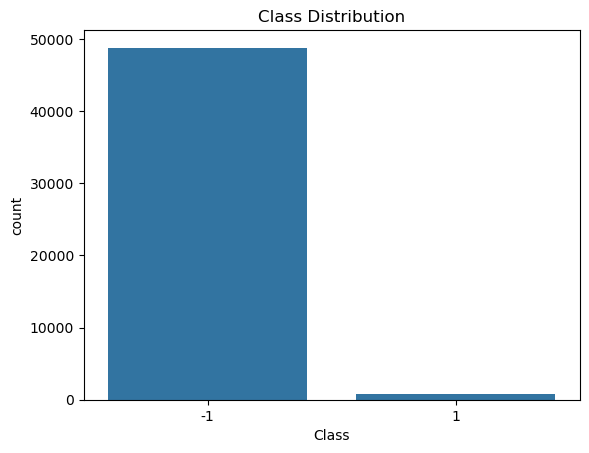

In [17]:
# General overview of the dataset
print("\nData Shape:")
print(df.shape)

# Split column groups to understand the number of features in each category
print("\nFeature Categories:")
info_cols = [col for col in df.columns if col.startswith('Info_')]
feat_cols = [col for col in df.columns if col.startswith('feat_')]
target_col = 'Class'

print(f"Info columns: {len(info_cols)}")
print(f"Feature columns: {len(feat_cols)}")
print(f"Target column: {target_col}")

# Understanding the basic structure of data - data types andd mssing values
print("\nData types:")
print(df.dtypes.value_counts())

print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Exploring the class distribution
print("\nClass distribution:")
print(df[target_col].value_counts(normalize=True))

sns.countplot(data=df, x=target_col)
plt.title("Class Distribution")
plt.show()

Key findings
> - The dataset comprises of 49,606 observations and 1,291 features - out of which 99.2% of the columns are features, and 0.69% are Info columns - indicating highly dimensional feature space.
> - The feature - `feat_esm1b_148` has the highest number of missing values - up to 90% of the entire data, while the rest of the features has at most less than 0.2% of the data missing.
> - The class variable is highly imbalanced, with a majority class `-1` representing 98.4% of the data. Predicting the minority class `1` of only 1.6% of the entire data will be challenging without addressing it by utilizing techniques such as `Cost-sensitive learning`, `SMOTE / ADASYN`

To handle the missing data, i'll drop the feature - `feat_esm1b_148`, and and consider imputing the rest with `Median`

### Validate the imputation choice
I'll perform more EDA to help me decide on the method of imputation - either `Mean` or `Median`

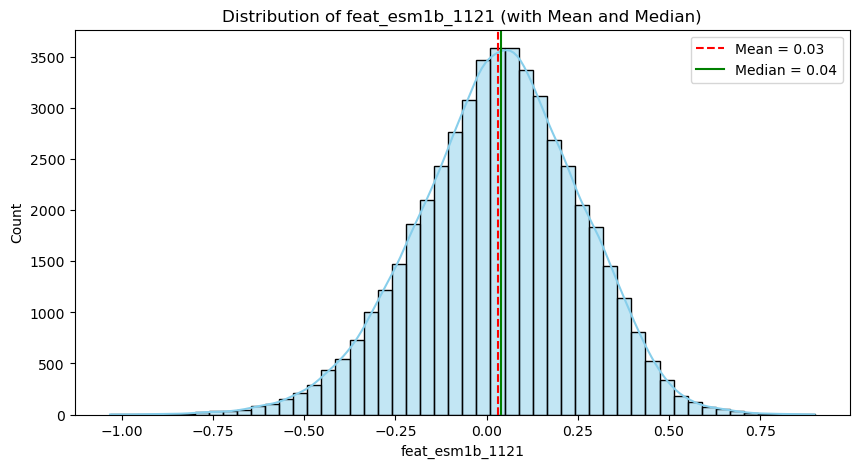

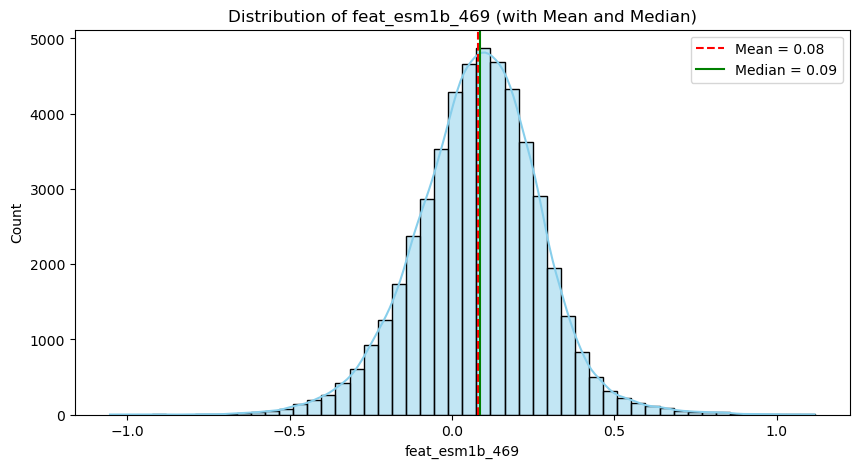

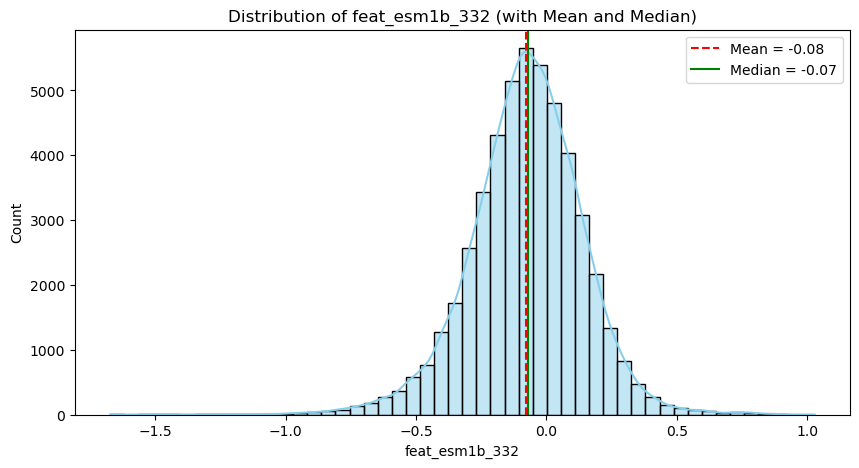

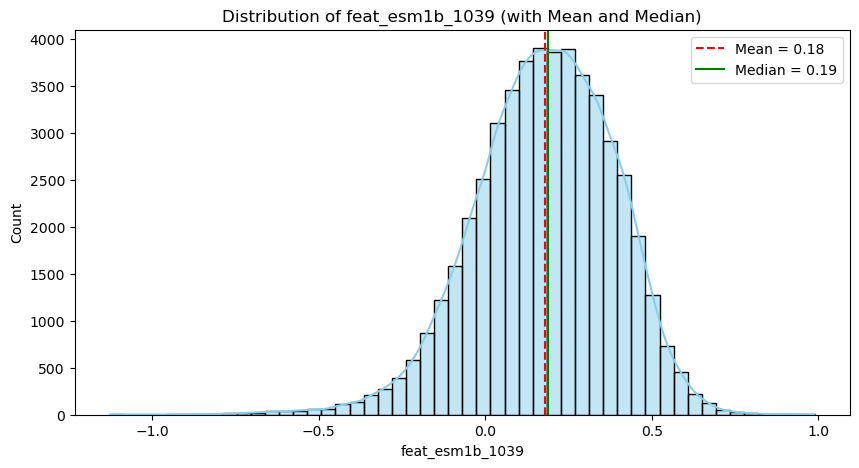

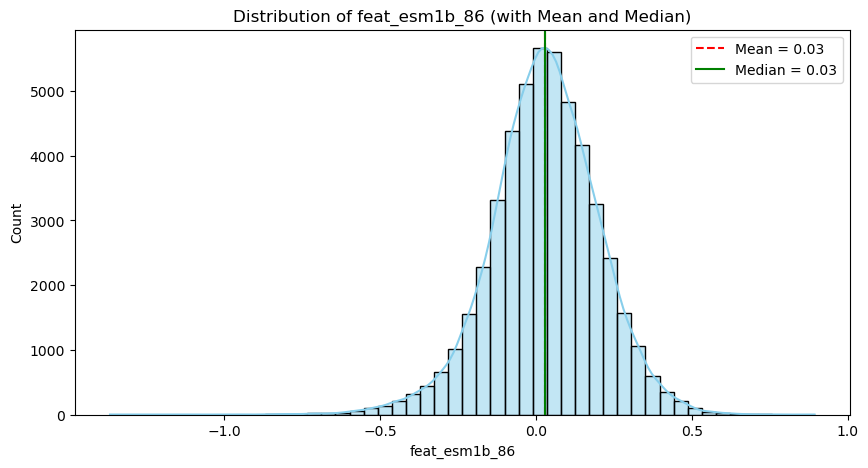

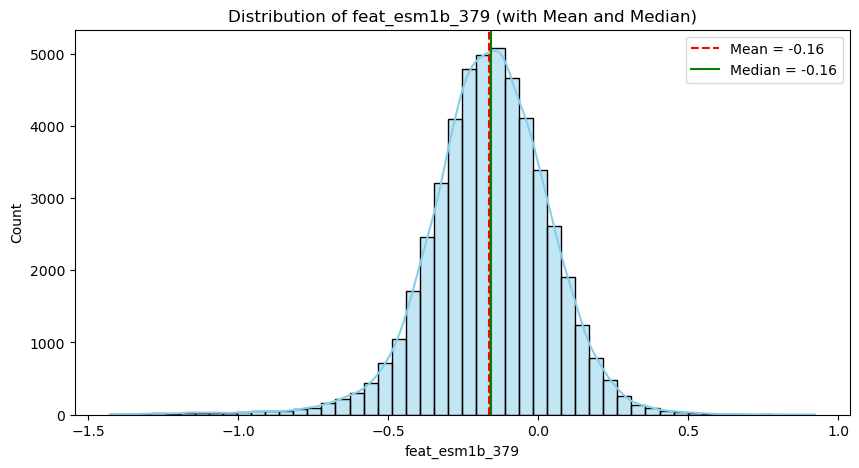


Skewness, Mean, and Median of Features with Missing Values:
feat_esm1b_1121: Skewness = -0.22, Mean = 0.03, Median = 0.04
feat_esm1b_469: Skewness = -0.07, Mean = 0.08, Median = 0.09
feat_esm1b_332: Skewness = -0.29, Mean = -0.08, Median = -0.07
feat_esm1b_1039: Skewness = -0.43, Mean = 0.18, Median = 0.19
feat_esm1b_86: Skewness = -0.28, Mean = 0.03, Median = 0.03
feat_esm1b_379: Skewness = -0.54, Mean = -0.16, Median = -0.16


In [18]:
from scipy.stats import skew

# Select a few features with missing values for visualization
# Here, we will visualize the distributions of features with significant missing values
missing_features = ['feat_esm1b_1121', 'feat_esm1b_469', 'feat_esm1b_332', 'feat_esm1b_1039', 'feat_esm1b_86', 'feat_esm1b_379']

# Visualize the feature's distributions
for feat in missing_features:
    plt.figure(figsize=(10, 5))

    sns.histplot(df[feat], kde=True, bins=50, color='skyblue')
    plt.axvline(df[feat].mean(), color='red', linestyle='--', label=f"Mean = {df[feat].mean():.2f}")
    plt.axvline(df[feat].median(), color='green', linestyle='-', label=f"Median = {df[feat].median():.2f}")
    plt.title(f'Distribution of {feat} (with Mean and Median)')
    plt.legend()
    plt.show()

# Quantify the Skewness of each feature
print("\nSkewness, Mean, and Median of Features with Missing Values:")
for feat in missing_features:
    skew_val = skew(df[feat].dropna())
    mean_val = df[feat].mean()
    median_val = df[feat].median()

    print(f"{feat}: Skewness = {skew_val:.2f}, Mean = {mean_val:.2f}, Median = {median_val:.2f}")


This result reveals that the features show:
> - Mild to moderate negative skew - though subtle, the mean can be pulled by the tail, while the median will remains stable in skewed distributions - mean is very sensitive to `outliers`
> - No severe skewness `|skewness| > 1`, hence, both `Mean` and `Median` could be acceptable for imputation
> - The differences between mean and median are small, which implies few or no extreme outliers in the features with missing value

Let's further visualize and compare effect of imputation with either `Mean` or `Median`

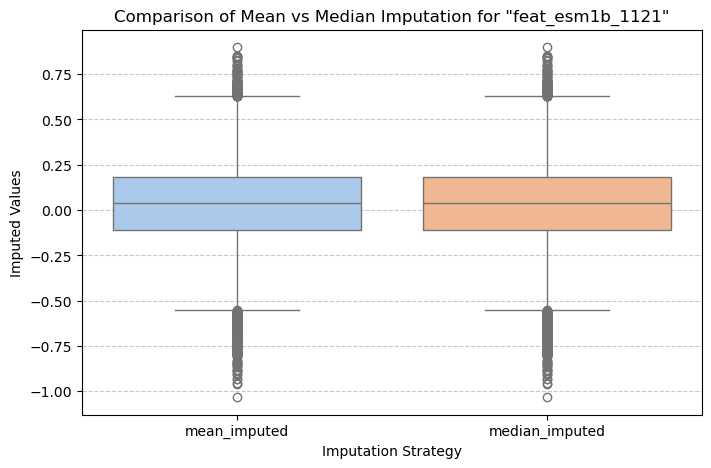

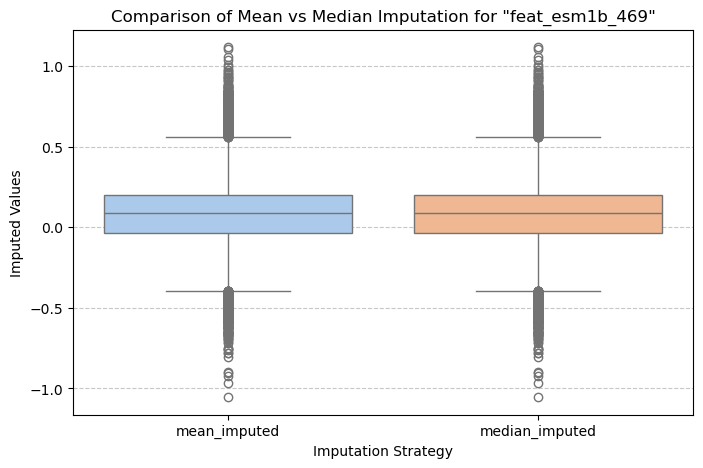

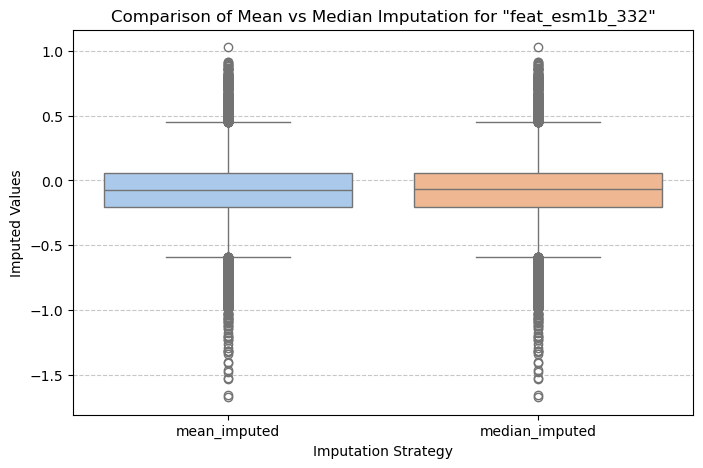

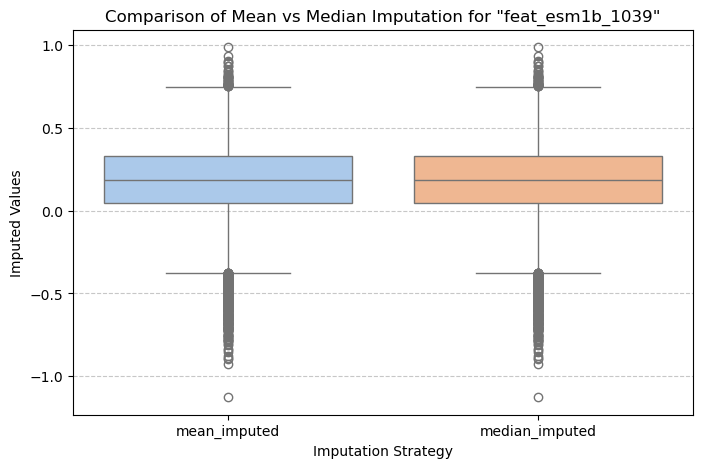

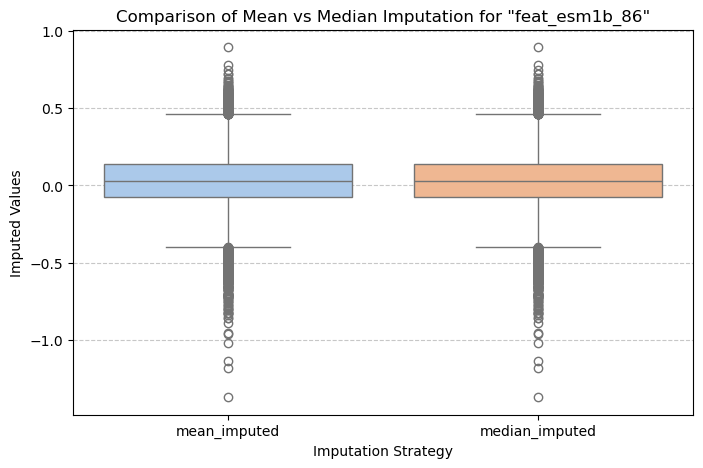

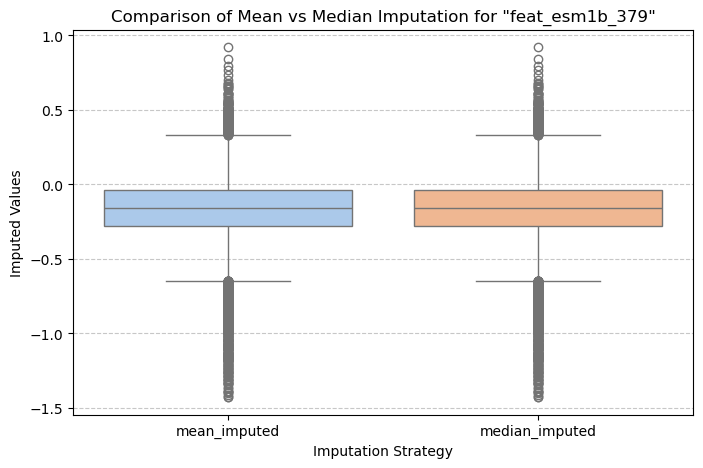

In [19]:
from sklearn.impute import SimpleImputer

for feat in missing_features:
    # Create a copy
    temp_df = df[[feat]].copy()

    # Impute using mean and median
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')

    # Perform imputation and flatten the output - fit_transform returns a 2D array
    temp_df['mean_imputed'] = mean_imputer.fit_transform(temp_df[[feat]]).ravel()
    temp_df['median_imputed'] = median_imputer.fit_transform(temp_df[[feat]]).ravel()

    # Melt the DataFrame for seaborn boxplot
    melted_df = temp_df.melt(value_vars=['mean_imputed', 'median_imputed'],
                            var_name='Imputation Strategy',
                            value_name='Value')

    # Plot boxplots
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=melted_df, x='Imputation Strategy', y='Value', palette='pastel', hue='Imputation Strategy', legend=False)
    plt.title(f'Comparison of Mean vs Median Imputation for "{feat}"')
    plt.ylabel('Imputed Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Though the visuals look identical, since the skewness is negative, and `Mean` is sensitive to outliers, even if subtle.
> `Median` imputation will be adopted.

### Data Cleaning

In [20]:
# Drop 'feat_esm1b_148' due to excessive missing values
df = df.drop(columns=['feat_esm1b_148'])

# Remove 'feat_esm1b_148' from feat_cols
feat_cols = [col for col in feat_cols if col != 'feat_esm1b_148']

# Define feature matrix X and target y
X = df[feat_cols]
y = df['Class']

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Check shape of data after imputation and confirm no missing values remain
print(f"X shape after imputation: {X_imputed.shape}")
print(f"Missing values remaining: {X_imputed.isnull().sum().sum()}")


X shape after imputation: (49606, 1280)
Missing values remaining: 0


#### Feature variance analysis
Feature variance analysis is necessary for dimensionality reduction and identification of uninformative predictors, it is basically a systematic assessment of feature variance to identify and remove low-variance (i.e. uninformative) features, thereby improving model efficiency and reducing noise in high-dimensional data

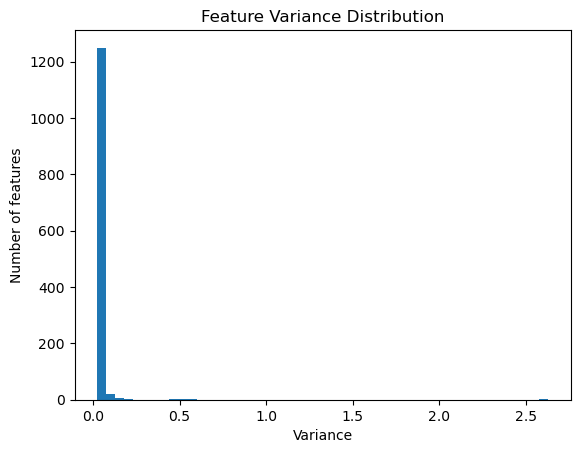

In [21]:
# Visualizing the Variance Threshold for feature selection
variances = X_imputed.var()
plt.hist(variances, bins=50)
plt.xlabel('Variance')
plt.ylabel('Number of features')
plt.title('Feature Variance Distribution')
plt.show()

This plot shows that majority of the features have variance threshold that is below `0.05`

In [22]:
# Numerically identifying the number of low-variance features
from sklearn.feature_selection import VarianceThreshold

for thresh in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]:
    selector = VarianceThreshold(threshold=thresh)
    selector.fit(X_imputed)
    num_removed = (~selector.get_support()).sum()
    print(f"Threshold {thresh}: {num_removed} features removed")

Threshold 0.01: 0 features removed
Threshold 0.02: 0 features removed
Threshold 0.03: 50 features removed
Threshold 0.04: 588 features removed
Threshold 0.05: 1016 features removed
Threshold 0.1: 1268 features removed


This result gives us some ideas on how to eliminate some features from our feature space - as features with variance less than 0.05 are likely to be uninformative for machine learning models. Low-variance features do not change much across samples, however, we would check the performance model after removing low-variance features to determine if such features would be retained or completely removed.

In [23]:
# Extracting low-variance features at a threshold of 0.05
selector = VarianceThreshold(threshold=0.05)  # Tune threshold if needed
selector.fit(X_imputed)
low_var_features = X_imputed.columns[~selector.get_support()]
print(f"Low-variance features: {len(low_var_features)}")

Low-variance features: 1016


These `low_var_features` would be dropped after confirming that our model performs better without them.

#### Identify the top 20 features by importance or variance

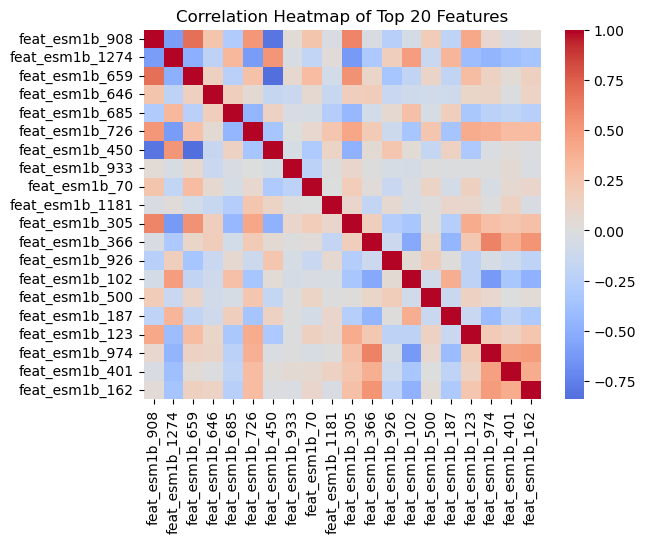

In [24]:
top_var_features = X_imputed.var().sort_values(ascending=False).head(20).index
sns.heatmap(X_imputed[top_var_features].corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Top 20 Features")
plt.show()


This heatmap reveals that `feat_esm1b_450` is highly correlated with `feat_esm1b_908` and `feat_esm1b_659`, indicating the presence of multicolinearity between the features.

#### Verifying suspected features

In [25]:
corr_matrix = X_imputed[top_var_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation > 0.8
high_corr_pairs = [(col, row, upper.loc[row, col])
                   for col in upper.columns
                   for row in upper.index
                   if upper.loc[row, col] > 0.8]

print("Highly correlated feature pairs (|corr| > 0.8):")
for pair in high_corr_pairs:
    print(pair)

Highly correlated feature pairs (|corr| > 0.8):
('feat_esm1b_450', 'feat_esm1b_908', 0.8005877884643648)
('feat_esm1b_450', 'feat_esm1b_659', 0.841468896719816)


These features are certainly highly correlated with `|corr| >= 0.8`, confirming our concern for multicolinearity. Hence, `feat_esm1b_450` will be dropped

#### Perform PCA to visualize the distribution of the classes
This will help us to visualize whether the minority class is deeply embedded or separable.

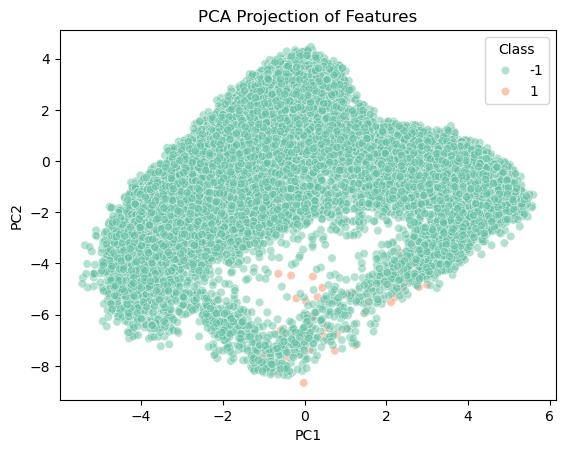

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imputed)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', palette='Set2', alpha=0.5)
plt.title('PCA Projection of Features')
plt.show()


> - This PCA chart suggests that the minority class represented as 1, shown in light orange is deeply embedded within the majority class represented as -1 and shown in green.
> - The minority points are scattered and overlapped by the majority, indicating poor separability in the first two principal components.
> - This suggests that distinguishing the minority class will be mostly challenging for our classification task. Hence, the need to drastically reduce the features for meaningful modelling

#### Rank the features by importance
This is to identify informative features to aid our feature reduction

In [27]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_imputed, y)
mi_series = pd.Series(mi_scores, index=X_imputed.columns).sort_values(ascending=False)
print("Top 10 Features by Mutual Information:\n", mi_series.head(10))


Top 10 Features by Mutual Information:
 feat_esm1b_1119    0.012166
feat_esm1b_733     0.011353
feat_esm1b_789     0.011249
feat_esm1b_450     0.011230
feat_esm1b_1134    0.010669
feat_esm1b_202     0.009329
feat_esm1b_1125    0.008592
feat_esm1b_1237    0.008545
feat_esm1b_292     0.008379
feat_esm1b_16      0.008127
dtype: float64


This result shows that `feat_esm1b_1119` is the most informative feature, with a `Mutual Information` score of `0.012166`,

In [28]:
mi_series.tail(200)

feat_esm1b_39      0.000270
feat_esm1b_817     0.000265
feat_esm1b_125     0.000264
feat_esm1b_690     0.000262
feat_esm1b_862     0.000260
                     ...   
feat_esm1b_49      0.000000
feat_esm1b_444     0.000000
feat_esm1b_48      0.000000
feat_esm1b_545     0.000000
feat_esm1b_1149    0.000000
Length: 200, dtype: float64

The bottom 200 features with the lowerest mutual information are mostly close to zero, indicating that they would not contribute meaningfully to the model.

#### Ploting the Mutual Information
We would plot the mutual information scores of all features to help us visualize these score - and aid us in deciding how to eliminate some uninformative features

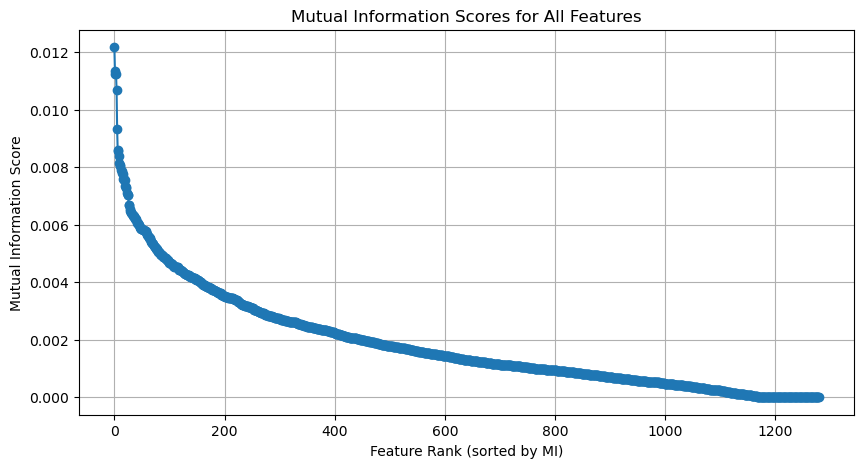

In [29]:
import matplotlib.pyplot as plt

# Plot sorted mutual information scores
plt.figure(figsize=(10, 5))
plt.plot(range(len(mi_series)), mi_series.values, marker='o')
plt.xlabel('Feature Rank (sorted by MI)')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for All Features')
plt.grid(True)
plt.show()

Based on this mutual information plot, I will select features by identifying the `elbow` point where the mutual information scores sharply decrease and the curve begins to flatten. This point indicates a transition from highly informative features to those that contribute little additional information. By choosing features up to this elbow, it ensures that only the most relevant predictors are retained for modeling, thereby reducing dimensionality and potential noise while preserving the majority of the predictive power in the dataset. However, the features will be adjust as needed based on model performance.



####  Distribution of Selected Top Features
Let's manually inspect the top 5 features for class-based separation

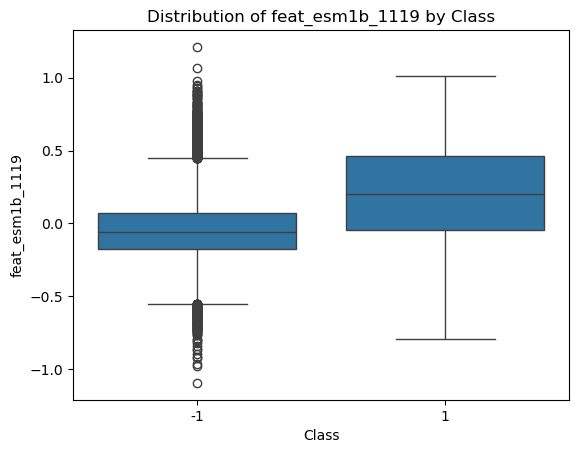

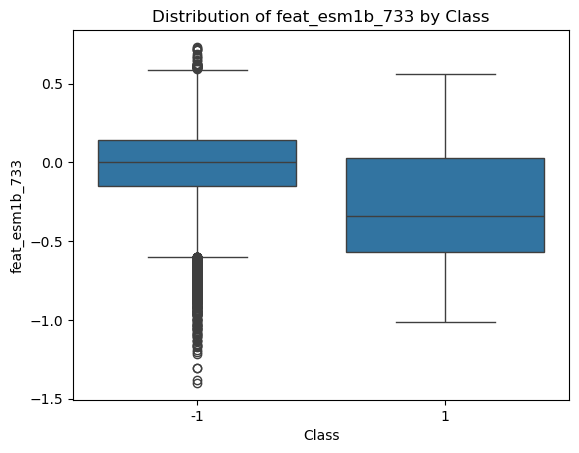

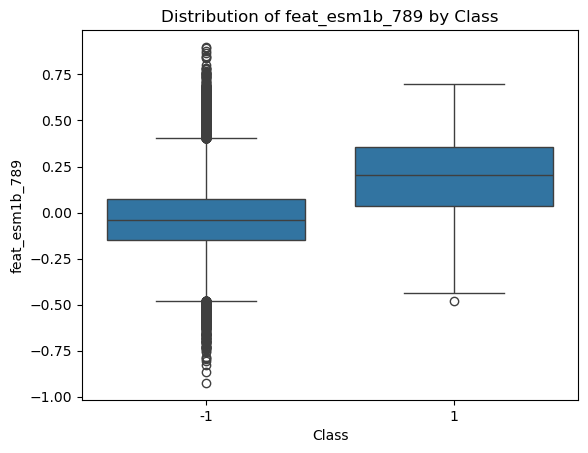

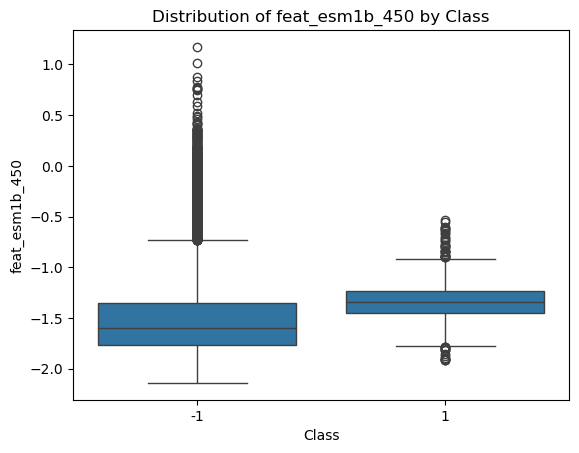

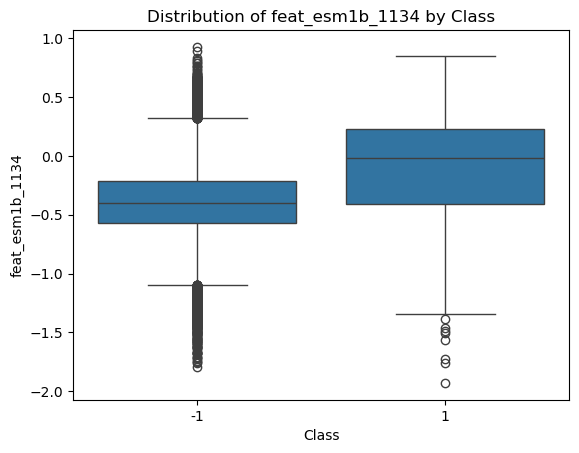

In [30]:
top_feats = mi_series.head().index
for col in top_feats:
    sns.boxplot(x=y, y=X_imputed[col])
    plt.title(f"Distribution of {col} by Class")
    plt.show()


This results reveal that there is differences in `medians` between the two classes, across the five feature, which reflects a shift in central tendency, suggesting that this features may help in distinguishing between the classes - signal of the predictive power of the features

Through these EDAs, we now understand that basically the most informative features fall within the range of 20 to 30 features. Let's use three different feature selection methods to select our features by applying these techniques to identify and retain only the most relevant features.

We will implement the `Filter` based feature selection methods - `Variance Threshold` and `Correlation based filtering`, the Wrapper method - `Recursive Feature Elimination`, the `Embedded` method - `L1-Regularized Logistic Regression`

#### Feature Selection

**Variance Threshold**
Analyzing the variance of the features to identify a reasonable variance threshold to start with for our dimentionality reduction.

In [31]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance < 0.05
for threshold in np.arange(0.01, 0.10, 0.01):
    print(f"Threshold: {threshold:.2f}", end=" - ")
    selector = VarianceThreshold(threshold=threshold)
    X_var = selector.fit_transform(X_imputed)
    print(f"Features Reduced from {X_imputed.shape[1]} to {X_var.shape[1]} features")


Threshold: 0.01 - Features Reduced from 1280 to 1280 features
Threshold: 0.02 - Features Reduced from 1280 to 1280 features
Threshold: 0.03 - Features Reduced from 1280 to 1230 features
Threshold: 0.04 - Features Reduced from 1280 to 692 features
Threshold: 0.05 - Features Reduced from 1280 to 264 features
Threshold: 0.06 - Features Reduced from 1280 to 104 features
Threshold: 0.07 - Features Reduced from 1280 to 52 features
Threshold: 0.08 - Features Reduced from 1280 to 26 features
Threshold: 0.09 - Features Reduced from 1280 to 15 features


For our modelling based on this result, we would select four representative thresholds and evaluate their effect on the model - `0.04`, `0.05`, `0.06`, and `0.07`

**Correlation based filter**
From previous EDA, we discovered highly correlated features at `|cor| > 0.8`, we would use this value to drop highly correlated features.

In [32]:
# Correlation matrix
corr_matrix = pd.DataFrame(X_imputed).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X_corr = pd.DataFrame(X_imputed).drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features")


Removed 2 highly correlated features


Selecting features based on the identified variance thresholds and two other embedded feature selection methods - `LogisticRegression` and `RandomForestClassifier`. We would determine the number of features retained at each threshold level from `0.04` to `0.07`

In [33]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Remove features with variance < 0.05
selector_04 = VarianceThreshold(threshold=0.04)
print('Results for threshold of 0.04')
X_var_thresh_04 = selector_04.fit_transform(X_imputed)
print(f"Variance Threshold method retained {X_var_thresh_04.shape[1]} features")

y_binary = (y == 1).astype(int)

log_model_04 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=3000, random_state=42)
embed_selector_lr_04 = SelectFromModel(log_model_04)
X_embed_lr_04 = embed_selector_lr_04.fit_transform(X_var_thresh_04, y_binary)
print(f"Embedded method retained {X_embed_lr_04.shape[1]} features")

rf_model_04 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
embed_selector_rf_04 = SelectFromModel(rf_model_04)
X_embed_rf_04 = embed_selector_rf_04.fit_transform(X_var_thresh_04, y_binary)
print(f"Tree-based method retained {X_embed_rf_04.shape[1]} features")

Results for threshold of 0.04
Variance Threshold method retained 692 features
Embedded method retained 160 features
Tree-based method retained 243 features


In [ ]:
# Remove features with variance < 0.05
selector_05 = VarianceThreshold(threshold=0.05)
print('Results for threshold of 0.05')
X_var_thresh_05 = selector_05.fit_transform(X_imputed)
print(f"Variance Threshold method retained {X_var_thresh_05.shape[1]} features")

y_binary = (y == 1).astype(int)

log_model_05 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=3000, random_state=42)
embed_selector_lr_05 = SelectFromModel(log_model_05)
X_embed_lr_05 = embed_selector_lr_05.fit_transform(X_var_thresh_05, y_binary)
print(f"Embedded method retained {X_embed_lr_05.shape[1]} features")

rf_model_05 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
embed_selector_rf_05 = SelectFromModel(rf_model_05)
X_embed_rf_05 = embed_selector_rf_05.fit_transform(X_var_thresh_05, y_binary)
print(f"Tree-based method retained {X_embed_rf_05.shape[1]} features")

Results for threshold of 0.05
Variance Threshold method retained 264 features
Embedded method retained 116 features
Tree-based method retained 94 features


In [35]:
# Remove features with variance < 0.06
selector_06 = VarianceThreshold(threshold=0.06)
print('Results for threshold of 0.06')
X_var_thresh_06 = selector_06.fit_transform(X_imputed)
print(f"Variance Threshold method retained {X_var_thresh_06.shape[1]} features")

y_binary = (y == 1).astype(int)

log_model_06 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=3000, random_state=42)
embed_selector_lr_06 = SelectFromModel(log_model_06)
X_embed_lr_06 = embed_selector_lr_06.fit_transform(X_var_thresh_06, y_binary)
print(f"Embedded method retained {X_embed_lr_06.shape[1]} features")

rf_model_06 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
embed_selector_rf_06 = SelectFromModel(rf_model_06)
X_embed_rf_06 = embed_selector_rf_06.fit_transform(X_var_thresh_06, y_binary)
print(f"Tree-based method retained {X_embed_rf_06.shape[1]} features")

Results for threshold of 0.06
Variance Threshold method retained 104 features
Embedded method retained 59 features
Tree-based method retained 39 features


In [36]:
# Remove features with variance < 0.07
selector_07 = VarianceThreshold(threshold=0.07)
print('Results for threshold of 0.07')
X_var_thresh_07 = selector_07.fit_transform(X_imputed)
print(f"Variance Threshold method retained {X_var_thresh_07.shape[1]} features")

y_binary = (y == 1).astype(int)

log_model_07 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=3000, random_state=42)
embed_selector_lr_07 = SelectFromModel(log_model_07)
X_embed_lr_07 = embed_selector_lr_07.fit_transform(X_var_thresh_07, y_binary)
print(f"Embedded method retained {X_embed_lr_07.shape[1]} features")

rf_model_07 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
embed_selector_rf_07 = SelectFromModel(rf_model_07)
X_embed_rf_07 = embed_selector_rf_07.fit_transform(X_var_thresh_07, y_binary)
print(f"Tree-based method retained {X_embed_rf_07.shape[1]} features")

Results for threshold of 0.07
Variance Threshold method retained 52 features
Embedded method retained 34 features
Tree-based method retained 19 features


For each of the variance thresholds between `0.05 and 0.07`, embedded methods - specifically `Logistic Regression` and `Random Forest Classifier` were used to further reduce the features by selecting the features with the most importance. The various categories of reduced features from the selected thresholds were modelled and the features reduced from the `0.04` threshold were used for further evaluations because those were the feature that had the most predictive effect on the models.

#### Modelling Pipeline

Let's build our final evaluation of the models using the `Info_cluster` feature for `GroupKFold` splitting, and apply `balanced_accuracy` score for model evaluation.

In [85]:
from sklearn.model_selection import GroupKFold, cross_val_score

# define the groups for GroupKFold spliting
groups = df['Info_cluster']  
group_kfold = GroupKFold(n_splits=5)


lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr_scores = cross_val_score(lr, X_embed_lr_05, y_binary, groups=groups, cv=group_kfold, scoring='balanced_accuracy')
print("Logistic Regression Balanced Accuracy:", lr_scores.mean())

Logistic Regression Balanced Accuracy: 0.6073440453806993


In [38]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_scores = cross_val_score(rf, X_var_thresh_04, y_binary, groups=groups, cv=group_kfold, scoring='balanced_accuracy', n_jobs=-1)
print("Random Forest Balanced Accuracy:", rf_scores.mean())

Random Forest Balanced Accuracy: 0.5088631338736861


In [39]:
from xgboost import XGBClassifier


xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_scores = cross_val_score(xgb_clf, X_var_thresh_04, y_binary, groups=groups, cv=group_kfold, scoring='balanced_accuracy')
print("XGBoost Balanced Accuracy:", xgb_scores.mean())

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:24:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:24:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:25:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:25:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati

XGBoost Balanced Accuracy: 0.5573139037352044


The above results show that the models performed better with `Variance Threshold` reduced features.

These models performed better with features selected using `0.04` variance threshold, hence we would use these reduced features to train a `CatBoostClassifier` model to better handle our imbalanced class.

In [66]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import balanced_accuracy_score
import numpy as np

thresholds = [
    X_var_thresh_05, X_var_thresh_06, X_var_thresh_07, 
    X_embed_lr_05, X_embed_lr_06, X_embed_lr_07, 
    X_embed_rf_05, X_embed_rf_06, X_embed_rf_07
]

for threshold in thresholds:
    print(f"Evaluating CatBoost on: {threshold.shape[1]} threshold retained features")

    # Defining CatBoost model
    cat_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='BalancedAccuracy',
        verbose=0,
        random_seed=42,
        auto_class_weights='Balanced'  # handles imbalance
    )

    scores = []

    for train_idx, val_idx in group_kfold.split(threshold, y_binary, groups=groups):
        X_train, X_val = threshold[train_idx], threshold[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train CatBoost
        cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

        # Predict and score
        y_pred = cat_model.predict(X_val)
        score = balanced_accuracy_score(y_val, y_pred)
        scores.append(score)

    print("CatBoost Balanced Accuracy Scores:", scores)
    print("Mean Balanced Accuracy:", np.mean(scores))
    print()

Evaluating CatBoost on: 264 threshold retained features
CatBoost Balanced Accuracy Scores: [0.7605551028722755, 0.7430688963929027, 0.9004621187915136, 0.8914071041084608, 0.7338214832571492]
Mean Balanced Accuracy: 0.8058629410844602

Evaluating CatBoost on: 104 threshold retained features
CatBoost Balanced Accuracy Scores: [0.7613373395803626, 0.7455111148233442, 0.8985591106725392, 0.8749886674389598, 0.7392669407342094]
Mean Balanced Accuracy: 0.8039326346498831

Evaluating CatBoost on: 52 threshold retained features
CatBoost Balanced Accuracy Scores: [0.7606101038908128, 0.76627191046094, 0.9073905135242852, 0.900803500798464, 0.7495890114400272]
Mean Balanced Accuracy: 0.8169330080229058

Evaluating CatBoost on: 116 threshold retained features
CatBoost Balanced Accuracy Scores: [0.7628050519454064, 0.7521489851683034, 0.9200547474717824, 0.894573406849311, 0.7570127389540482]
Mean Balanced Accuracy: 0.8173189860777704

Evaluating CatBoost on: 59 threshold retained features
CatBoo

This `CatBoostClassifier` was modelled on the various categories of reduced features from the selected thresholds ranging from `0.05` to `0.07`, and the `Logistic Regression` further reduced features of `116` had the highest `Balanced Accuracy` score of `0.8173` to out performed the initial `LogisticRegression` model which had an accuracy of `0.6037`

Let's further use `Optuna` to tune the `hyperparameters` of the model to see if we can improve this performance.

In [67]:
import optuna

def objective(trial):
    # Hyperparameters to tune
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10),
        "auto_class_weights": "Balanced",
        "verbose": 0,
        "random_seed": 42,
        "thread_count": 2,
        "task_type": "CPU", 
    }

    model = CatBoostClassifier(**params)

    scores = []
    for train_idx, test_idx in group_kfold.split(X_embed_lr_05, y_binary, groups=groups):
        X_train, X_test = X_embed_lr_05[train_idx], X_embed_lr_05[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)
        preds = model.predict(X_test)
        score = balanced_accuracy_score(y_test, preds)
        scores.append(score)

    return np.mean(scores)

# ----- Run Optuna -----
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800)  # 30 trials or 30 mins

# ----- Output Best Params -----
print("Best Balanced Accuracy Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-07-29 15:17:19,379] A new study created in memory with name: no-name-203ef222-b42f-405b-a704-ba1b1cd67bd2
[I 2025-07-29 15:18:02,661] Trial 0 finished with value: 0.8058678549946151 and parameters: {'iterations': 419, 'depth': 6, 'learning_rate': 0.05694926373218082, 'l2_leaf_reg': 5.533993560849633, 'border_count': 164, 'random_strength': 1.98606161923406}. Best is trial 0 with value: 0.8058678549946151.
[I 2025-07-29 15:20:02,276] Trial 1 finished with value: 0.7623224309385439 and parameters: {'iterations': 873, 'depth': 10, 'learning_rate': 0.2665716091495467, 'l2_leaf_reg': 8.254934634553848, 'border_count': 220, 'random_strength': 0.8512139409413693}. Best is trial 0 with value: 0.8058678549946151.
[I 2025-07-29 15:20:33,759] Trial 2 finished with value: 0.775078146184569 and parameters: {'iterations': 886, 'depth': 7, 'learning_rate': 0.2356736301756039, 'l2_leaf_reg': 5.242359085681191, 'border_count': 135, 'random_strength': 5.749950038824825}. Best is trial 0 with val

Best Balanced Accuracy Score: 0.811832419584545
Best Hyperparameters: {'iterations': 737, 'depth': 4, 'learning_rate': 0.010235849419174242, 'l2_leaf_reg': 3.4116167414878866, 'border_count': 32, 'random_strength': 3.8685521243592036}


This model's scores dropped behind the previous which had a `Balanced Accuracy` score of `0.8173`. Hence, the final model will be trained using the previous setup with `iterations = 500`, and the `116` retained features with the most predictive accuracy.


#### Training Final Model

In [78]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import balanced_accuracy_score
import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Load the dataset
df = pd.read_csv('df.csv', sep=';', engine='python')

# Separate info columns and feature columns
info_cols = [col for col in df.columns if col.startswith('Info_')]
feat_cols = [col for col in df.columns if col.startswith('feat_')]

# Drop 'feat_esm1b_148' due to excessive missing values
df = df.drop(columns=['feat_esm1b_148'])

# Remove 'feat_esm1b_148' from feat_cols
feat_cols = [col for col in feat_cols if col != 'feat_esm1b_148']

# Define feature matrix X and target y
X = df[feat_cols]
y = df['Class']

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Remove features with variance < 0.05
selector_05 = VarianceThreshold(threshold=0.05)
X_var_thresh_05 = selector_05.fit_transform(X_imputed)

# Get the mask of retained features
var_mask = selector_05.get_support()
var_retained_feature_names = X_imputed.columns[var_mask]
print(f"Variance Threshold method retained {X_var_thresh_05.shape[1]} features")

# Use Logistic Regression for embedded feature selection to reduce the features further
log_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=3000, random_state=42)
lr_selector = SelectFromModel(log_model)
X_selected = lr_selector.fit_transform(X_var_thresh_05, y_binary)

# Get mask of features retained by logistic regression
lr_mask = lr_selector.get_support()

# Final feature names after both steps
final_selected_features = var_retained_feature_names[lr_mask]
print(f"Total final selected features = {X_selected.shape[1]}")


# define the groups for GroupKFold spliting
X = X_selected
y = (y == 1).astype(int) # Convert class to binary

groups = df['Info_cluster']  

# GroupKFold Evaluation
group_kfold = GroupKFold(n_splits=5)
balanced_acc_scores = []

# Defining CatBoost model
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='BalancedAccuracy',
    verbose=0,
    random_seed=42,
    auto_class_weights='Balanced'
)

for fold, (train_idx, test_idx) in enumerate(group_kfold.split(X, y, groups=groups)):
    print(f"\n Fold {fold + 1}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train CatBoost
    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    # Predict and score
    y_pred = model.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred)
    balanced_acc_scores.append(score)

    print(f"Fold {fold + 1} Balanced Accuracy: {score:.4f}")

mean_score = np.mean(balanced_acc_scores)
print(f"\n Mean Balanced Accuracy Across Folds: {mean_score:.4f}")

final_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='BalancedAccuracy',
    verbose=0,
    random_seed=42,
    auto_class_weights='Balanced'
)

final_model.fit(X, y)
final_model.save_model("catboost_groupkfold_model.cbm")
joblib.dump(final_model, "catboost_groupkfold_model.pkl")


Variance Threshold method retained 264 features
Total final selected features = 116

 Fold 1
Fold 1 Balanced Accuracy: 0.7628

 Fold 2
Fold 2 Balanced Accuracy: 0.7521

 Fold 3
Fold 3 Balanced Accuracy: 0.9201

 Fold 4
Fold 4 Balanced Accuracy: 0.8946

 Fold 5
Fold 5 Balanced Accuracy: 0.7570

 Mean Balanced Accuracy Across Folds: 0.8173


['catboost_groupkfold_model.pkl']

This result shows that a total of `116` features out of `1280` overall features were used to train the model, which had a balanced accuracy of `81.7%`.

#### Visualize feature importance

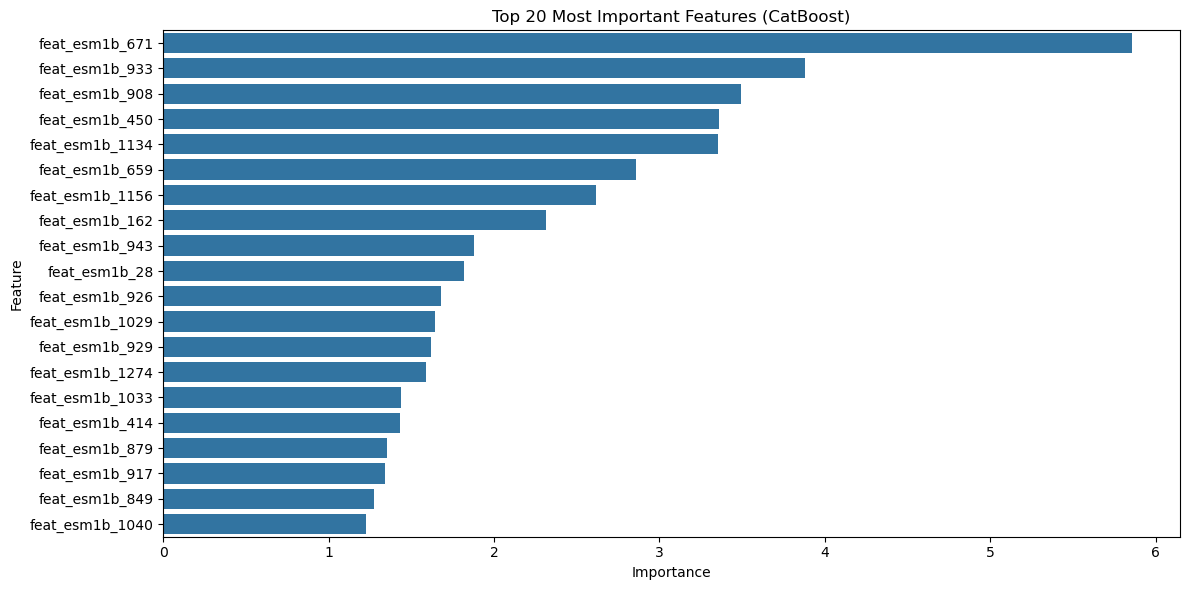

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances
importances = final_model.get_feature_importance()

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': final_selected_features,
    'Importance': importances
})

# Sort by descending importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Top 20 most important features
top_features = feature_importance_df.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title("Top 20 Most Important Features (CatBoost)")
plt.tight_layout()
plt.show()



#### Result Summary

> Using a hybrid feature selection pipeline (Variance Threshold at 0.05 followed by L1-regularized Logistic Regression), the feature space was reduced from 1280 to 116. The final CatBoost model trained on these features to achieved a balanced accuracy of 81.7%, demonstrating robust performance despite significant dimensionality reduction.